The goal for this project will be to determine how often a "long block" occurs within the block chain. For the purpose of this project, we will define a "long block" as any block that has a timestamp greater than 2 hours since the previous block in the chain.

In [8]:
import os

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from google.cloud import bigquery
from scipy import stats

We collect the static data from Google BigQuery: https://cloud.google.com/blog/topics/public-datasets/bitcoin-in-bigquery-blockchain-analytics-on-public-data
This data is updated every 10 minutes, so it usually has the latest block data. However, it requires you to setup a BigQuery account and project. For simplicity, I have included a saved CSV file you can load from.

In [5]:
def collect_data(from_saved: bool=True, fpath: str='') -> list[tuple]:
    if from_saved:
        data = []
        if fpath == '':
            fpath = os.path.join(os.getcwd(), 'data', 'blockdata.csv')
        with open(fpath, 'r') as infile:
            for line in infile.readlines():
                block_num, block_time = line.strip('\n').split(',')
                block_num = int(block_num)
                block_time = dt.datetime.fromisoformat(block_time) # 2009-01-10 04:45:58+00:00
                data.append((block_num, block_time))
            
        return data
    else:
        """
        Note that you will need to setup big query locally if you want to
        query live data: 
        https://cloud.google.com/bigquery/docs/reference/libraries#setting_up_authentication
        """
        client = bigquery.Client()
        
        query = """
            SELECT number, timestamp
            FROM `bigquery-public-data.crypto_bitcoin.blocks`
        """
        
        query_job = client.query(query)
        query_results = query_job.result(timeout=30)
        data = [row.values() for row in query_results]
        
        return data
    
block_data = collect_data(from_saved=True)

We can investigate the data and see it is a list of tuples, with the block number and timestamp of the block.

In [6]:
block_data[:5]

[(0, datetime.datetime(2009, 1, 3, 18, 15, 5, tzinfo=datetime.timezone.utc)),
 (1, datetime.datetime(2009, 1, 9, 2, 54, 25, tzinfo=datetime.timezone.utc)),
 (2, datetime.datetime(2009, 1, 9, 2, 55, 44, tzinfo=datetime.timezone.utc)),
 (3, datetime.datetime(2009, 1, 9, 3, 2, 53, tzinfo=datetime.timezone.utc)),
 (4, datetime.datetime(2009, 1, 9, 3, 16, 28, tzinfo=datetime.timezone.utc))]

Our goal is to identify how often a long block occurs, as we defined above. Essentially, this means we want to calculate how long it takes for a new long block to occur. 

For example, if block 0 took 2 hours, block 1 took 10 minutes, block 2 took 1 hour, and block 3 took 2.5 hours, we know that block 0 and block 3 are both long blocks. Then the difference between long block 0 and long block 3 is 10 min + 1 hour + 2.5 hours.

In [7]:
def calc_time_between_long_blocks(block_data: list[tuple], threshold: int=2*60*60) -> list[float]:
    """
    We want to identify the time difference between "long" blocks. Long blocks
    in this case refers to blocks that took more than 2 hours to mine. Our convention
    is to include the mining time into this time difference.
    For example, if block 0 took 2 hours, block 1 took 10 minutes, block 2 took 1 hour,
    and block 3 took 2.5 hours, then the difference between long block 0 and long block 3
    is 10 min + 1 hour + 2.5 hours.

    Parameters
    ----------
    block_data : list[tuple]
        Tuple format should be (block_num: int, timestamp: datetime).
    threshold : int:
        Threshold in seconds of how we define a long block (default is 2 hours)
    Returns
    -------
    list[float]
        Return a list of all the calculated times between long blocks.
    """
    block_data = sorted(block_data, key=lambda tup: tup[0]) # sort on block num ascending
    tstamps = [z[1] for z in block_data]
    inter_block_times = []
    last_ts = tstamps[0]
    
    for i in range(1, len(tstamps)):
        diff = (tstamps[i] - tstamps[i-1]).total_seconds()
        if diff > threshold:
            inter_time = (tstamps[i] - last_ts).total_seconds()
            inter_block_times.append(inter_time)
            last_ts = tstamps[i]
    return inter_block_times

inter_event_times = calc_time_between_long_blocks(block_data)

Let's take the log base 10 of this and plot a histogram to see what it looks like.

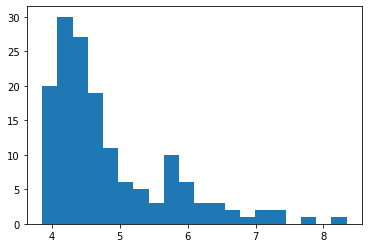

In [9]:
log_times = np.log10(inter_event_times)
_ = plt.hist(log_times, bins=20)

We can see that most of the inter times are between 10^4 and 10^5 seconds, or roughly 2.7 hrs to 27.7 hours. Using this plot, we can try and model a distribution to determine the probability of the inter time being within a certain value. For this, we will use a Weibull distribution, which is commonly used in survival analysis: https://en.wikipedia.org/wiki/Weibull_distribution

In [11]:
def fit_weibull_dist(data: list[float], loc: float=4.0) -> tuple:
    params = stats.exponweib.fit(data, loc=loc)
    return params

fitted_params = fit_weibull_dist(log_times)

Let's now plot the fitted distribution on top of the data we have.

Text(0.5, 0, 'Log10 Time (s)')

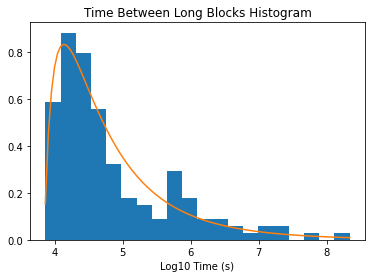

In [14]:
plot_x = np.linspace(min(log_times), max(log_times), 100)
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
_ = ax1.hist(log_times, bins=20, density=True)
ax1.plot(plot_x, stats.exponweib.pdf(plot_x, *fitted_params))
ax1.set_title('Time Between Long Blocks Histogram')
ax1.set_xlabel('Log10 Time (s)')


We can use this distribution to determine the probability of a long block occuring within the next T seconds. The probability is proportional to the area under the distribution curve. For example, in the plot above we see for (log time) less than 7, the area is greater than for 6. Alternatively, for time *greater* than 7, it is much smaller than *less* than 7. In other words, it is much more likely for a long block to occur within 10^7 seconds than it is for it to take longer than 10^7 seconds. 

It is helpful to construct a survival function from this distribution.

Text(0.5, 0, 'Log10 Time (s)')

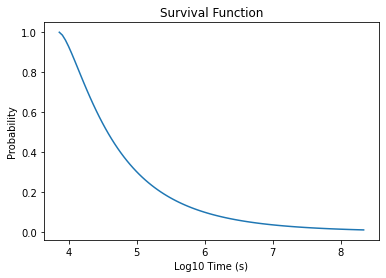

In [19]:
sf = stats.exponweib.sf(plot_x, *fitted_params)
0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(plot_x, sf)
ax.set_title('Survival Function')
ax.set_ylabel('Probability')
ax.set_xlabel('Log10 Time (s)')

This essentially tells us the probability of it taking X seconds before we see another long block. Intuitively, the longer time has passed since we last saw a long block, the less probability we will continue to NOT see another one.

Using this, we can ask questions like "What is the probability I will see a long block within X seconds?"

In [20]:
def prob_lblock_within_t(time: int, data: list[float], wb_params: tuple) -> float:
    x = np.linspace(min(data), max(data), 100)
    surv_func = stats.exponweib.sf(x, *wb_params)
    
    log_time = np.log10(time)
    
    index = np.where(x < log_time)[0][-1]
    return round(100 * (1 - surv_func[index]), 2)

within_time = 24 * 60 * 60 # 24 hours
lblock_prob = prob_lblock_within_t(within_time, log_times, fitted_params)

print(f'Probability long block will occur within {within_time} seconds: {lblock_prob}%')

Probability long block will occur within 86400 seconds: 66.23%


The total number of long blocks is just the length of the inter event times we calculated

In [25]:
n_long_blocks = len(log_times)
print(f'Total number of long blocks so far: {n_long_blocks}')

Total number of long blocks so far: 152


If we wanted just a single number for average time between long blocks, we could simply take the total time of the block chain divided by the total number of long blocks.

In [28]:
block_data = sorted(block_data, key=lambda tup: tup[0])
total_time = (block_data[-1][1] - block_data[0][1]).total_seconds()

avg_time = total_time / n_long_blocks
avg_time_days = avg_time / (24 * 60 * 60)
print(f'Average days between long blocks: {avg_time_days}')

Average days between long blocks: 31.847203262061402


However, there is an issue we need to be careful of. It turns out, almost all of the long blocks occur within the first year of the blockchain. This likely points to some systematic differences over time.

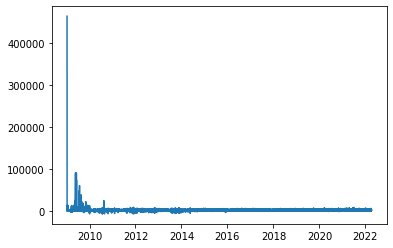

In [29]:
dates = [z[1] for z in block_data]
diffs = [(dates[i] - dates[i-1]).total_seconds() for i in range(1, len(dates))]

plt.plot(dates[1:], diffs)

We can see that this easily skews our data in our previous distribution. In fact, if we only look at the last 10 years, we see very few long blocks.

In [41]:
import pytz
start = np.where(np.array(dates) >= dt.datetime(2012, 1, 1, tzinfo=pytz.utc))[0][0]
trimmed_event_times = calc_time_between_long_blocks(block_data[start:])

print(f'Number of long blocks since 2012: {len(trimmed_event_times)}')

avg_days = np.mean(trimmed_event_times) / (24 * 60 * 60)
print(f'Average days between long blocks: {avg_days}')

Number of long blocks since 2012: 4
Average days between long blocks: 867.3831365740741
